In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from grid_world.Gridworld import Gridworld

In [7]:
game = Gridworld(size=4, mode='static')

game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [8]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [9]:
game.reward()

-1

In [10]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [16]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
)

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9 # discount factor
epsilon = 1.0 # initialized as 1 and then decrease

In [17]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 't',
}

In [28]:
epochs = 1000

def train(epochs):
    losses = []
    global epsilon

    for i in range(epochs):
        game = Gridworld(size=4, mode='static')
        state_ = game.board.render_np().reshape(1, 64) \
            + np.random.rand(1, 64) / 10.0
        state1 = torch.from_numpy(state_).float()
        is_over = False

        while (not is_over):
            # runs the Q-network to calculate the Q values for all actions
            qval = model(state1)
            qval_ = qval.data.numpy()
            # use epsilon-greedy to select an action
            if random.random() < epsilon:
                action_ = np.random.randint(0, 4)
            else:
                action_ = np.argmax(qval_)

            # take the action
            action = action_set[action_]
            game.makeMove(action)
            # after making the move, finds the maximum Q value from the
            # new state
            state2_ = game.board.render_np().reshape(1, 64) \
                + np.random.rand(1, 64) / 10.0
            state2 = torch.from_numpy(state2_).float()
            reward = game.reward()
            with torch.no_grad():
                newQ = model(state2.reshape(1, 64))
            maxQ = torch.max(newQ)

            if reward == -1:
                Y = reward + (gamma * maxQ)
            else:
                Y = reward

            Y = torch.Tensor([Y]).detach()
            X = qval.squeeze()[action_]
            loss = loss_fn(X, Y)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            state1 = state2
            if reward != -1:
                is_over = True

        if epsilon > 0.1:
            epsilon -= (1/epochs)

    return losses


In [29]:
losses = train(epochs)

/Users/bifnudozhao/miniconda3/envs/tensorflow/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


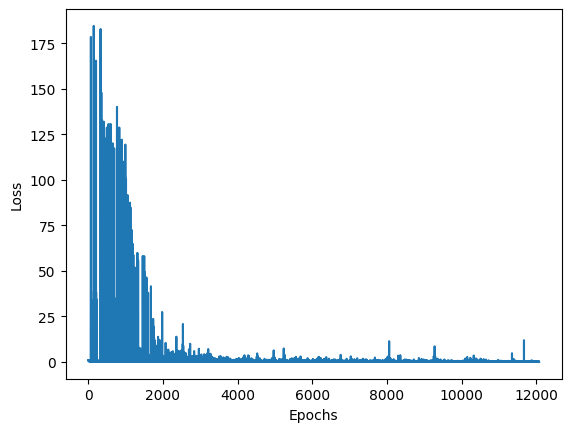

In [33]:
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(len(losses)), losses)

In [36]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(size=4, mode=mode)
    state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
    state = torch.from_numpy(state_).float()

    if display:
        print('Initial State:')
        print(test_game.display())
    
    status = 1
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1, 64) + np.random.rand(1, 64) / 10.0
        state = torch.from_numpy(state_).float()

        if display:
            print(test_game.display())
        reward = test_game.reward()

        if reward != -1:
            if reward > 0:
                status = 2
                if display:
                    print('Game won! Reward %s' % (reward, ))
            else:
                status = 0
                if display:
                    print('Game lost! Reward %s' % (reward, ))

        i += 1
        if (i > 15):
            if display:
                print('Game lost, too many moves')
            break

    win = True if status == 2 else False
    return win


In [37]:
test_model(model, 'static')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' 'P' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward 10


True

In [38]:
test_model(model, 'random')

Initial State:
[['-' 'P' ' ' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 0; Taking action: l
[['-' ' ' ' ' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Game lost! Reward -10


False

In [44]:
win_count = 0
total_test_games = 1000

for i in range(total_test_games):
    does_win = test_model(model, 'random', False)
    if does_win:
        win_count += 1

print('win rate in random mode: %d/%d' % (win_count, total_test_games))

win rate in random mode: 193/1000
